# Tutorial of SIAC Filtering

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a><br />This tutorial by Xiaozhou Li is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  
All code examples are also licensed under the [MIT license](http://opensource.org/licenses/MIT).

## What is SIAC Filtering
A standard definition of SIAC Filtering is a B-spline based convolution processing technique.  The name SIAC means Smoothness-Increasing Accuracy-Conserving.  The formulation can be written as
$$ u_h^{\star}(x) = (K_h\star u_h)(x) = \int_{-\infty}^{\infty}K_h(x - \xi)u_h(\xi) d\xi, $$
where $K_h$ is the so-called SIAC filter.

## A Review of B-spline
First, we recall the definition of B-splines given by de Boor \cite{Boor:2001}.

__B-spline__ 

Let $\mathbf{t}:= (t_j)$ be a __nondecreasing sequence__ of real numbers that create a so-called knot sequence. The $j$th B-spline of order $\ell$ for the knot sequence $\mathbf{t}$ is denoted by $B_{j,\ell,\mathbf{t}}$ and is defined, for $\ell=1$, by the rule
\begin{equation}
    B_{j,1,\mathbf{t}}(x) =
        \left\{\begin{array}{ll}
        1, & t_j \leq x < t_{j+1}; \\
        0, & \text{otherwise}.
        \end{array} \right.
\end{equation}
In particular, $t_j = t_{j+1}$ leads to $B_{j,1,\mathbf{t}} = 0.$ For $\ell > 1$,
\begin{align*}
 B_{j,\ell,\mathbf{t}}(x)
= \omega_{j,k,\mathbf{t}}B_{j,\ell-1,\mathbf{t}} +
(1 - \omega_{j+1,\ell,\mathbf{t}})B_{j+1,\ell-1,\mathbf{t}},
\end{align*}
with
$$ \omega_{j,\ell,\mathbf{t}}(x) = \frac{x-t_j}{t_{j+\ell-1}-t_{j}}.$$

- The knot sequence $\mathbf{t}$ also represents the so-called breaks of the B-spline. 
- The B-spline in the region $[t_i, t_{i+1}),\, i = 0,\ldots,\ell-1$ is a polynomial of degree $\ell-1$, but in the entire support $[t_0,t_{\ell}]$, the B-spline is a piecewise polynomial. 
- When the knots $(t_j)$ are sampled in a symmetric and equidistant fashion, the B-spline is called a central B-spline. 

__Central B-spline__

A central B-spline of order $\ell$ has a knot sequence that is uniformly spaced and symmetrically distributed 
$$\mathbf{t}=-\frac{\ell}{2},-\frac{\ell-2}{2},\cdots,\frac{\ell-2}{2},\frac{\ell}{2}.$$
For convenience, we denote $\psi_{\mathbf{t}}^{(\ell)}(x)$ to be the $0^{th}$ B-spline of order $\ell$ for the knot sequence $\mathbf{t}$, 
$$\psi_{\mathbf{t}}^{(\ell)}(x) = B_{0,\ell,\mathbf{t}}(x).$$



In [2]:
# environment setting, before any codes
import numpy as np
import numpy.polynomial.legendre as npleg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output, display

### Implementing of B-splines
Here, we adopt de Boor's algorithm B-spline to implement B-spline
```python
    def bspline(x, order, T)
```
where
- $x$: the evaluation point 
- $k$: the order of B-spline (polynomial degree $= order-1$)
- $T$: $T[0], \ldots, T[order]$ the nodes b-spline
Note:
- One has to be careful once the evaluation point $x$ is located at the end nodes of the B-spline. It is the reason to introduce the $tiny$ variable$.

In [3]:
def bspline(x, order, T):
    tiny = 1.e-13
    if (x < T[0]-tiny or x > T[order]+tiny):
        return 0.
    else:
        if (np.abs(x - T[0])) < tiny:
            x = T[0] + 2*tiny
        if (np.abs(x - T[order])) < tiny:
            x = T[order] - 2*tiny 
        for i in range(order):
            if (x >= T[i]-tiny and x < T[i+1]-tiny):
                left = i
                break
        B1 = np.zeros(order+1)
        B1[left] = 1.
        for i in range(1,order):
            B2 = B1
            for j in range(0,order-i):
                if (B2[j] < tiny):
                    termL = 0.
                else:
                    termL = (x - T[j])/(T[i+j] - T[j])*B2[j]
                if (B2[j+1] < tiny):
                    termR = 0.
                else:
                    termR = (T[i+j+1] - x)/(T[i+j+1] - T[j+1])*B2[j+1]
                B1[j] = termL + termR
        return B1[0]

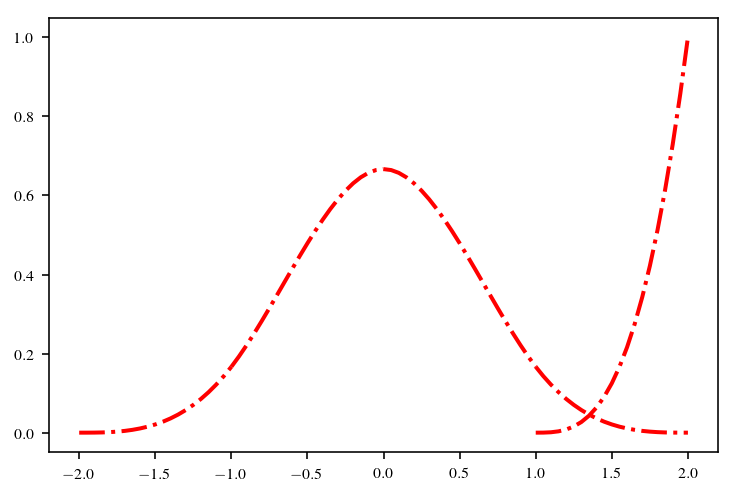

In [4]:
def plot_bspline(order,T):
    samples = 21
    tiny = 1.e-13
    for i in range(np.size(T)-1):
        if (np.abs(T[i] - T[i+1]) > tiny):
            x = np.linspace(T[i], T[i+1], samples)
            y = np.zeros(samples)
            for j in range(samples):
                y[j] = bspline(x[j], order, T)
            plt.plot(x, y,'-.r',linewidth=2)

order = 4
T1 = np.array([-2, -1, 0, 1, 2])
T2 = np.array([1, 2, 2, 2, 2])
plot_bspline(order,T1)
plot_bspline(order,T2)
plt.show()

## Construction of the Simplest SIAC Filter
In the early literatures like \cite{Bramble:1977} and \cite{Cockburn:2003}, the classic filter is defined as 
\begin{equation}
    K^{(2k+1,k+1)}(x) = \sum\limits_{\gamma=0}^{2k}c^{(2k+1,k+1)}_{\gamma}\psi^{(k+1)}\left(x - x_\gamma\right),
\end{equation}
where $x_\gamma = \gamma - k$ and $\psi^{(k+1)}$ is the $(k+1)$th order __central B-spline__.  The scaled filter used for filtering is given by
$$ K_h^{(2k+1,k+1)}(x) = \frac{1}{h}K^{(2k+1,k+1)}\left(\frac{x}{h}\right). $$
Here, we follow the extensions in \cite{Li:2015} for a more general framework
\begin{equation}
    K^{(r+1,\ell)}(x) = \sum\limits_{\gamma=0}^{r}c^{(r+1,\ell)}_{\gamma}\psi^{\ell}\left(x - \eta x_\gamma\right),
\end{equation}
where $x_\gamma = \eta\left(\gamma - \frac{r}{2}\right)$ and $\psi^{\ell}$ is the $\ell$th order __central B-spline__.  Furthermore, $r+1$ is the number of B-splines and $\eta$ is the compression factor.

### The nodes matrix 
To design a general framework to construct the filter, we introduce the concept of nodes matrix.  

__nodes matrix:__

A nodes matrix,  $T$, is an $(r+1) \times (\ell+1)$ matrix such that the $\gamma-$th row, $T[\gamma,:]$, of the matrix $T$ is a nodes sequence with $\ell+1$ elements that are used to create the B-spline $\psi_{T[\gamma,:]}^{\ell}(x)$.  The number of rows $r+1$ is specified based on the number of B-splines used to construct the filter. 

As we mensioned before, the $\ell$th order central B-spline has the nodes sequence 
$$\left[-\frac{\ell}{2},-\frac{\ell-2}{2},\cdots,\frac{\ell-2}{2},\frac{\ell}{2}\right],$$
which leads 
$$T[\gamma,:] = \eta x_\gamma + \left[-\frac{\ell}{2},-\frac{\ell-2}{2},\cdots,\frac{\ell-2}{2},\frac{\ell}{2}\right],$$
or
$$T[j, i] = i - \frac{\ell}{2} + \eta \left(j - \frac{r}{2}\right).$$

In [5]:
def generate_nodes_T(num, order, compress):
    T = np.zeros([num,order+1])
    for j in range(num):
        for i in range(order+1):
            T[j,i] = i - 0.5*order + compress*(j - 0.5*(num-1))
    return T
##k = 1
##print (generate_nodes_T(2*k+1, k+1, 1))

### Coefficient
After defined the B-splines used to construct the filter, the only thing remains is to decide the coefficient, $\left\{c^{(r+1,\ell)}_\gamma\right\}_{\gamma=0}^r$.  The coefficients are decided by implementing the property that the filter reproduces polynomials by convolution up to degree $r$, 
\begin{equation}
    K^{(r+1,\ell)} \star p = p, \quad p = 0, x, ..., x^{r}.
\end{equation}
Using the monomials as in the above equation we can obtain the following linear system for the filter coefficients:
\begin{equation}
    \sum\limits_{\gamma=0}^{r} c_\gamma^{(r+1,\ell)}\int_{-\infty}^\infty \psi^{(\ell)}(\xi - x_\gamma)(x - \xi)^m d\xi = x^m, \,\, m = 0, 1,\ldots,r.
\end{equation}
In order to calculate the integration exactly, we use Gaussian quadrature with $\lceil\frac{\ell+m+1}{2}\rceil$ quadrature points. As an example for $k=1$ ($r = 2k, \ell=k+1$), we have
\begin{equation}
    \label{eq-Matrix}
    \left[
        \begin{array}{ccc}
            1 & 1 & 1\\
            x-1& x & x+1 \\
            x^2+2x+\frac{7}{6} & x^2 + \frac{1}{6} & x^2-2x+\frac{7}{6}
        \end{array}
    \right]
    \left[
        \begin{array}{c}
            c_0 \\
            c_1 \\
            c_2 \\
        \end{array}
    \right]
    = 
    \left[
        \begin{array}{c}
            1 \\
            x \\ 
            x^2 \\
        \end{array}
    \right].
\end{equation}
Since this linear system holds for all $x$, we can simply set $x=0$ and obtain the coefficients $[c_0, c_1, c_2]^{T} = [ -\frac{1}{12}, \frac{7}{6}, -\frac{1}{12}]^T$.


In [6]:
def generate_coeff(num, order, T):
    Gpn = int(np.ceil(0.5*(num+order)))
    xg, wg = np.polynomial.legendre.leggauss(Gpn)
    A = np.zeros([num,num])
    b = np.zeros([num])
    b[0] = 1.
    for i in range(num):
        for j in range(num):
            for l in range(order):
                xm = 0.5*(T[j,l] + T[j,l+1])
                xr = 0.5*(T[j,l+1] - T[j,l])
                for m in range(Gpn):
                    A[i,j] += xr*wg[m]*bspline(xm+xr*xg[m], \
                                               order, T[j,:])* \
                            (-xr*xg[m]-xm)**i
    c = np.linalg.solve(A,b)
    return c

In [7]:
def filter(x, num, order, T, c):
    sum = 0.
    for j in range(num):
        sum += c[j]*bspline(x, order, T[j,:])
    return sum

def plot_filter(num, order, T, c):
    samples = 1001
    x = np.linspace(T[0,0], T[num-1,order], samples)
    y = np.zeros(samples)
    for i in range(samples):
        y[i] = filter(x[i], num, order, T, c)
    plt.plot(x,y,'-k',linewidth=2)

Filter Coefficients:   [-0.08333333  1.16666667 -0.08333333]



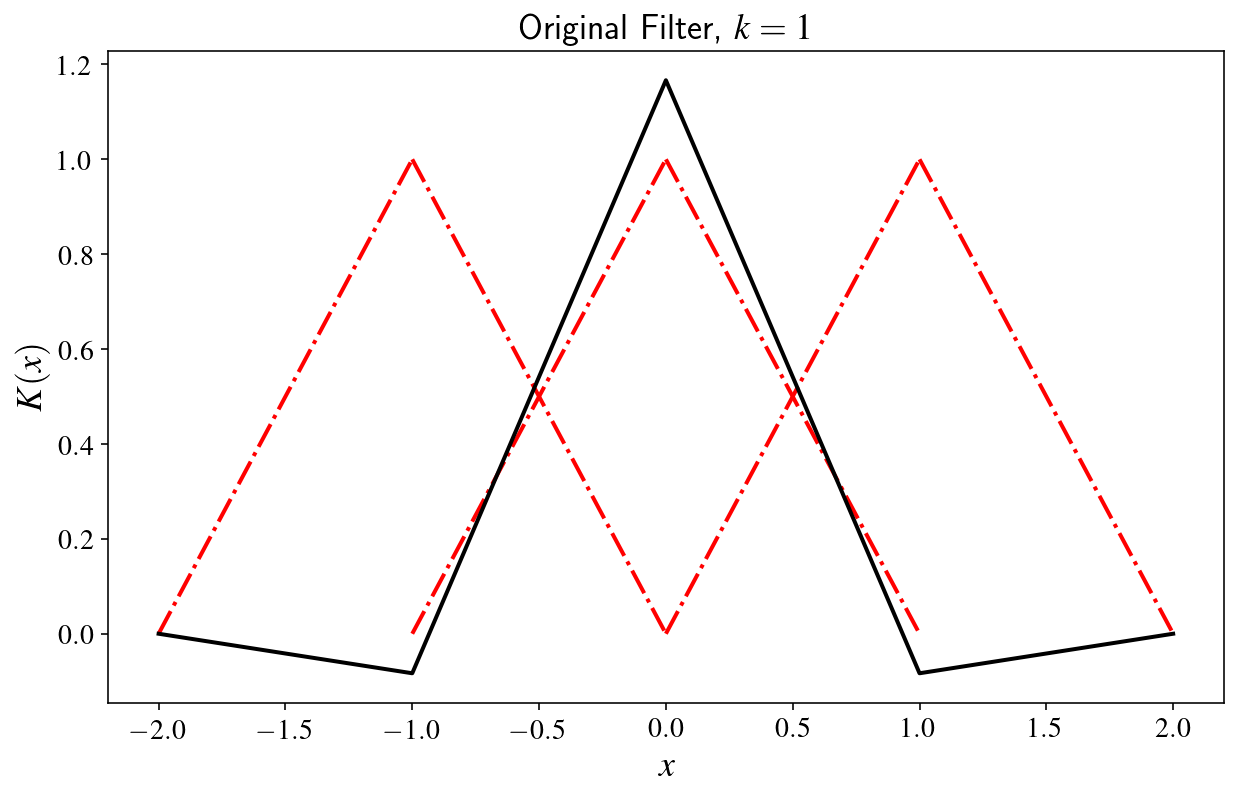

In [8]:
def original_filter(degree):
    num = 2*degree + 1
    order = degree + 1

    T = generate_nodes_T(num, order, 1)
    c = generate_coeff(num, order, T)
    print ('Filter Coefficients:  ', c)
    print ()
    plt.figure(figsize=(10,6))
    for i in range(num):
        plot_bspline(order, T[i,:])
    plot_filter(num, order, T, c)
    plt.xlabel('$x$',fontsize=18)
    plt.ylabel('$K(x)$',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title('Original Filter, $k = '+str(degree)+'$',fontsize=18)
    plt.show()

w = interactive(original_filter, degree=widgets.IntSlider(min=1,max=5,value=1))
display(w)
#interact(original_filter, degree=widgets.IntSlider(min=1,max=5,value=1))

## Filtering
\begin{equation}
    u_h(x) = \sum\limits_{j=1}^N\sum\limits_{l = 0}^k \phi_n^l(x).
\end{equation}

### DG Solution
In this tutorial, we do not include the DG codes.  Instead, we will input the DG solution, then apply the filtering.

Note:

Since t
Extended Precision
Python's floating-point numbers are usually 64-bit floating-point numbers, nearly equivalent to np.float64. In some unusual situations it may be useful to use floating-point numbers with more precision. Whether this is possible in numpy depends on the hardware and on the development environment: specifically, x86 machines provide hardware floating-point with 80-bit precision, and while most C compilers provide this as their long double type, MSVC (standard for Windows builds) makes long double identical to double (64 bits). NumPy makes the compiler’s long double available as np.longdouble (and np.clongdouble for the complex numbers). You can find out what your numpy provides with``np.finfo(np.longdouble)``.

NumPy does not provide a dtype with more precision than C long double``s; in particular, the 128-bit IEEE quad precision data type (FORTRAN's ``REAL*16) is not available.

# References

(<a id="cit-Boor:2001" href="#call-Boor:2001">de Boor, 2001</a>) Carl de Boor, ``_A practical guide to splines_'',  2001.

(<a id="cit-Bramble:1977" href="#call-Bramble:1977">Bramble and Schatz, 1977</a>) Bramble J. H. and Schatz A. H., ``_Higher order local accuracy by averaging in the finite element
              method_'', Math. Comp., vol. 31, number 137, pp. 94--111,  1977.

(<a id="cit-Cockburn:2003" href="#call-Cockburn:2003">Cockburn, Luskin <em>et al.</em>, 2003</a>) Cockburn Bernardo, Luskin Mitchell and Shu Endre, ``_Enhanced accuracy by post-processing for finite element
              methods for hyperbolic equations_'', Math. Comp., vol. 72, number 242, pp. 577--606,  2003.  [online](http://dx.doi.org/10.1090/S0025-5718-02-01464-3)

(<a id="cit-Li:2015" href="#call-Li:2015">Li, 2015</a>) Xiaozhou Li, ``_Smoothness-Increasing and Accuracy-Conserving (SIAC) Filters for Discontinuous Galerkin Methods._'',  2015.

